In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import seaborn as sns
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num = [str(i) for i in range(135)]

In [3]:
p1 = [read_csv('ics_data_preprocessed/07_Smart_Meter_65/P1/1000/' + n + '.csv', squeeze=True, parse_dates=['ts'], index_col='ts') for n in num]

In [4]:
def prepare_data(df, num_elements=50):
    new_data = []
    length = df.shape[0]
    current_index = 0
    step = int(0.2 * num_elements)
    while(current_index <= length - num_elements):
        new_data.append(df[current_index:current_index+num_elements])
        current_index += step
    return new_data

In [5]:
p1 = [prepare_data(df) for df in p1]
p1 = sum(p1, [])

In [6]:
p1

[ts
 2019-10-02 23:30:51    184.0
 2019-10-02 23:30:52    182.6
 2019-10-02 23:30:53    183.8
 2019-10-02 23:30:54    183.8
 2019-10-02 23:30:55    183.8
 2019-10-02 23:30:56    182.4
 2019-10-02 23:30:57    181.8
 2019-10-02 23:30:58    183.4
 2019-10-02 23:30:59    183.4
 2019-10-02 23:31:00    183.6
 2019-10-02 23:31:01    182.8
 2019-10-02 23:31:02    182.2
 2019-10-02 23:31:03    183.2
 2019-10-02 23:31:04    183.2
 2019-10-02 23:31:05    182.8
 2019-10-02 23:31:06    183.0
 2019-10-02 23:31:07    181.8
 2019-10-02 23:31:08    181.8
 2019-10-02 23:31:09    182.8
 2019-10-02 23:31:10    182.4
 2019-10-02 23:31:11    183.0
 2019-10-02 23:31:12    182.4
 2019-10-02 23:31:13    182.4
 2019-10-02 23:31:14    183.2
 2019-10-02 23:31:15    182.4
 2019-10-02 23:31:16    183.2
 2019-10-02 23:31:17    183.2
 2019-10-02 23:31:18    181.6
 2019-10-02 23:31:19    182.6
 2019-10-02 23:31:20    183.0
 2019-10-02 23:31:21    182.8
 2019-10-02 23:31:22    182.8
 2019-10-02 23:31:23    182.2
 2019-

In [7]:
p1 = [df.values for df in p1]

In [67]:
len(p1)

246

In [25]:
# p1_train = np.array([l[:-test_size] for l in p1])
# p1_test = np.array([l[-test_size:] for l in p1])
p1_train = p1[:150]
p1_val = p1[150:200]
p1_test = p1[200:]

In [26]:
input_size = int(len(p1_test[0]) * 0.8)

In [27]:
X_train = [df[:input_size] for df in p1_train]
y_train = [df[input_size:] for df in p1_train]

X_val = [df[:input_size] for df in p1_val]
y_val = [df[input_size:] for df in p1_val]

X_test = [df[:input_size] for df in p1_test]
y_test = [df[input_size:] for df in p1_test]

In [43]:
trainX = Variable(torch.Tensor(np.array(X_train)).unsqueeze(-1))
trainY = Variable(torch.Tensor(np.array(y_train)))
# x2 = x1.unsqueeze(0)
valX = Variable(torch.Tensor(np.array(X_val)))
valY = Variable(torch.Tensor(np.array(y_val)))

testX = Variable(torch.Tensor(np.array(X_test)))
testY = Variable(torch.Tensor(np.array(y_test)))

In [44]:
trainX.shape

torch.Size([150, 40, 1])

In [45]:
trainY.shape

torch.Size([150, 10])

In [46]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [47]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [48]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [51]:
INPUT_DIM = 1
OUTPUT_DIM = 1
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
HID_DIM = 128
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, 'cpu')#.to(device)

In [52]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1, 64)
    (rnn): LSTM(64, 128, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1, 64)
    (rnn): LSTM(64, 128, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [56]:
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

In [58]:
for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

TypeError: forward() missing 1 required positional argument: 'trg'

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(p1_train)
val_arr = scaler.transform(p1_val)
test_arr = scaler.transform(p1_test)

In [10]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [70]:
test_size = 10

In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(p1_train)

In [72]:
train_data_normalized = torch.FloatTensor(train_data_normalized)

In [73]:
train_data_normalized

tensor([[ 0.8473,  0.8594,  0.8594,  ...,  0.8500,  0.4427, -0.7164],
        [ 0.8459,  0.8579,  0.8481,  ...,  0.8921,  0.4449, -0.7190],
        [ 0.8571,  0.8776,  0.8608,  ...,  0.8612,  0.4493, -0.7162],
        ...,
        [-0.9944, -0.9916, -0.9845,  ..., -0.9846, -0.9847, -0.9983],
        [-0.9552, -0.9902, -0.9902,  ..., -0.9958, -0.9935, -0.9987],
        [-0.9342, -0.9297, -0.9887,  ..., -0.9846,  1.0000,  1.0000]])

In [74]:
train = np.array([l[:-test_size] for l in p1_train])
test = np.array([l[-test_size:] for l in p1_train])

In [103]:
class LSTM(nn.Module):
    def __init__(self, input_size=40, hidden_layer_size=100, output_size=10):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [104]:
model = nn.LSTM(input_size = 40, hidden_size = 100)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [102]:
print(model)

LSTM(40, 100)


In [97]:
epochs = 50

for i in range(epochs):
    for seq, labels in zip(train_data_normalized, test_data_normalized):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
#         print(model.hidden_cell)

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

RuntimeError: input.size(-1) must be equal to input_size. Expected 40, got 1

In [84]:
test_in = np.array([l[:-test_size] for l in p1_test])
test_out = np.array([l[-test_size:] for l in p1_test])

In [86]:
test_outputs = []

In [87]:
model.eval()

for item in test_in:
    seq = torch.FloatTensor(item)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_outputs.append(model(seq).item())

In [88]:
test_outputs

[2.1251869201660156,
 2.2166225910186768,
 2.4403533935546875,
 2.5277693271636963,
 2.686293363571167,
 2.686326742172241,
 2.6853621006011963,
 2.686645269393921,
 2.6865394115448,
 2.686814546585083,
 2.69547700881958,
 2.886920213699341,
 2.873028516769409,
 2.8723859786987305,
 2.8770744800567627,
 2.883500337600708,
 2.868589162826538,
 2.877638101577759,
 2.876537799835205,
 2.872680425643921,
 2.872384786605835,
 2.8763575553894043,
 2.8970706462860107,
 2.871009588241577,
 2.8770453929901123,
 2.8746678829193115,
 2.8683629035949707,
 2.728508949279785,
 2.632395029067993,
 2.6025452613830566,
 2.610011577606201,
 2.6011035442352295,
 2.6135406494140625,
 2.600507974624634,
 2.584923028945923,
 2.5837323665618896,
 2.582487106323242,
 2.5853302478790283,
 2.585456132888794,
 2.584803581237793,
 2.584599018096924,
 2.584268808364868,
 2.5838208198547363,
 2.7735719680786133,
 2.7741212844848633,
 2.773838996887207]

In [89]:
actual_predictions = scaler.inverse_transform(np.array(test_outputs).reshape(-1, 1))
print(actual_predictions)

ValueError: non-broadcastable output operand with shape (46,1) doesn't match the broadcast shape (46,50)

In [1]:
import torch
import torch.nn as nn

from pandas import read_csv
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

# 1s

## 50 values

In [11]:
num = [str(i) for i in range(135)]

In [12]:
p1 = [read_csv('ics_data_preprocessed/07_Smart_Meter_65/P1/1000/' + n + '.csv', squeeze=True, parse_dates=['ts'], index_col='ts') for n in num]

In [7]:
def prepare_data(df, num_elements=50):
    new_data = []
    length = df.shape[0]
    current_index = 0
    step = int(0.2 * num_elements)
    while(current_index <= length - num_elements):
        new_data.append(df[current_index:current_index+num_elements])
        current_index += step
    return new_data

In [14]:
p1 = [prepare_data(df, 50) for df in p1]
p1 = sum(p1, [])
p1 = [df.values.tolist() for df in p1]

In [15]:
train, test = train_test_split(p1, test_size=0.2, random_state=42)

In [16]:
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# train_data_normalized = scaler.fit_transform(train)
# test_data_normalized = scaler.transform(test)
train_data_normalized = train
test_data_normalized = test

In [17]:
train_data, val_data = train_test_split(train_data_normalized, test_size=0.15, random_state=42)

In [18]:
train_data = torch.FloatTensor(train_data)
val_data = torch.FloatTensor(val_data)
test_data = torch.FloatTensor(test_data_normalized)

In [19]:
X_train = train_data[:, :-10]
y_train = train_data[:, -10:]
X_val = val_data[:, :-10]
y_val = val_data[:, -10:]
X_test = test_data[:, :-10]
y_test = test_data[:, -10:]

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=10):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [10]:
best_model = LSTM()
loss_function = nn.MSELoss()

In [26]:
losses = []
val_losses = []
    
for hidden_layer_size in [100, 150, 200, 300]:
    model = LSTM(hidden_layer_size=hidden_layer_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 75
    

    
    for i in range(epochs):
        
        model.train()
        for (seq, labels) in zip(X_train, y_train):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            losses.append(single_loss)
            single_loss.backward()
            optimizer.step()

        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
            
        model.eval()

        with torch.no_grad():
            val_lo = []
            for (seq, labels) in zip(X_val, y_val):
                y_pred = model(seq)

                single_loss = loss_function(y_pred, labels)
                val_lo.append(single_loss)

            if (len(val_losses) == 0) or (sum(val_lo) < val_losses[-1]):
                best_model = model
            
            val_losses.append(sum(val_lo))
            
        if (len(losses) > 1) and (abs(losses[-1] - losses[-2]) / losses[-1] > 0.05) and (losses[-1] > losses[-2]):
            break

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.0260742642
epoch:   1 loss: 0.05465012
epoch:   1 loss: 0.0627985373
epoch:   0 loss: 0.0524561964
epoch:   0 loss: 0.0706609786


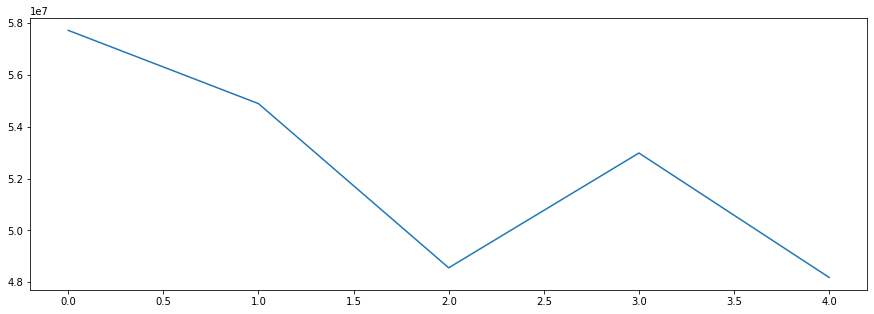

In [27]:
plt.plot(val_losses)

In [28]:
predictions = []
best_model.eval()
with torch.no_grad():
    predictions = [best_model(seq) for (seq, labels) in zip(X_test, y_test)]
    
#             val_lo = []
#         for (seq, labels) in zip(X_test, y_test):
#             y_pred = best_model(seq)
#             single_loss = loss_function(y_pred, labels)

#             if (len(val_losses) == 0) or (sum(val_lo) < val_losses[-1]):
#                 best_model = model
            
#             val_losses.append(sum(val_lo))

In [29]:
pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]

In [30]:
# actual_predictions = scaler.inverse_transform(np.array([np.array(i) for i in pred]))
actual_predictions = np.array([np.array(i) for i in pred])

In [31]:
mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]

In [32]:
print(sum(mape) / len(mape))

0.02107442431514738


In [33]:
rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]

In [34]:
print(sum(rmse) / len(rmse))

54.466102231489046


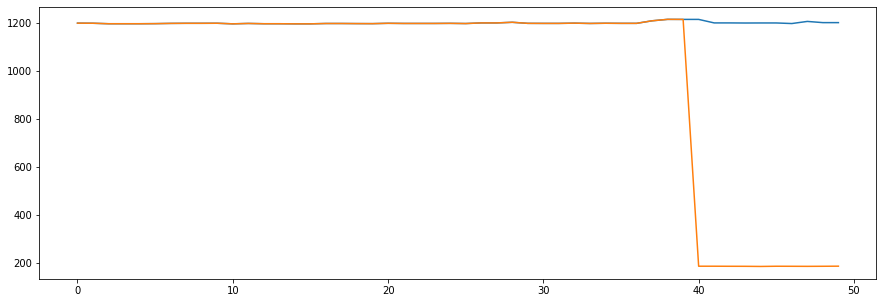

In [35]:
index = 4

plt.plot(test[index])
plt.plot(actual_predictions[index])

In [4]:
def learn(num, count, data_len):
    num = [str(i) for i in range(num)]
    p1 = [read_csv('ics_data_preprocessed/07_Smart_Meter_65/P1/' + str(count) + '/' + n + '.csv', squeeze=True, parse_dates=['ts'], index_col='ts') for n in num]
    
    p1 = [prepare_data(df, data_len) for df in p1]
    p1 = sum(p1, [])
    p1 = [df.values.tolist() for df in p1]
    train, test = train_test_split(p1, test_size=0.2, random_state=42)
    train_data_normalized = train
    test_data_normalized = test
    train_data, val_data = train_test_split(train_data_normalized, test_size=0.15, random_state=42)
    train_data = torch.FloatTensor(train_data)
    val_data = torch.FloatTensor(val_data)
    test_data = torch.FloatTensor(test_data_normalized)
    X_train = train_data[:, :-10]
    y_train = train_data[:, -10:]
    X_val = val_data[:, :-10]
    y_val = val_data[:, -10:]
    X_test = test_data[:, :-10]
    y_test = test_data[:, -10:]
    
    best_model = LSTM()
    loss_function = nn.MSELoss()
    losses = []
    val_losses = []
    
    for hidden_layer_size in [50, 100, 150, 200]:
        model = LSTM(hidden_layer_size=hidden_layer_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
        epochs = 75
        
        for i in range(epochs):
        
            model.train()
            for (seq, labels) in zip(X_train, y_train):
                optimizer.zero_grad()
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                     torch.zeros(1, 1, model.hidden_layer_size))

                y_pred = model(seq)

                single_loss = loss_function(y_pred, labels)
                losses.append(single_loss)
                single_loss.backward()
                optimizer.step()

            if i%25 == 1:
                print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
            
            model.eval()

            with torch.no_grad():
                val_lo = []
                for (seq, labels) in zip(X_val, y_val):
                    y_pred = model(seq)

                    single_loss = loss_function(y_pred, labels)
                    val_lo.append(single_loss)

                if (len(val_losses) == 0) or (sum(val_lo) < val_losses[-1]):
                    best_model = model
                
                val_losses.append(sum(val_lo))
                
            if (len(losses) > 1) and (abs(losses[-1] - losses[-2]) / losses[-1] > 0.05) and (losses[-1] > losses[-2]):
                break

        print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    plt.plot(val_losses)
    return best_model
     

In [5]:
def evaluate(model):
    predictions = []
    model.eval()
    with torch.no_grad():
        predictions = [best_model(seq) for (seq, labels) in zip(X_test, y_test)]
        pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]
        actual_predictions = np.array([np.array(i) for i in pred])
    mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]
    print(sum(mape) / len(mape))
    rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]
    print(sum(rmse) / len(rmse))

epoch:   1 loss: 0.34105760
epoch:   3 loss: 0.0438032039
epoch:   0 loss: 0.0858908743
epoch:   0 loss: 0.0844115391
epoch:   0 loss: 11.3218431473
0.021074448236515074
54.4661032657036


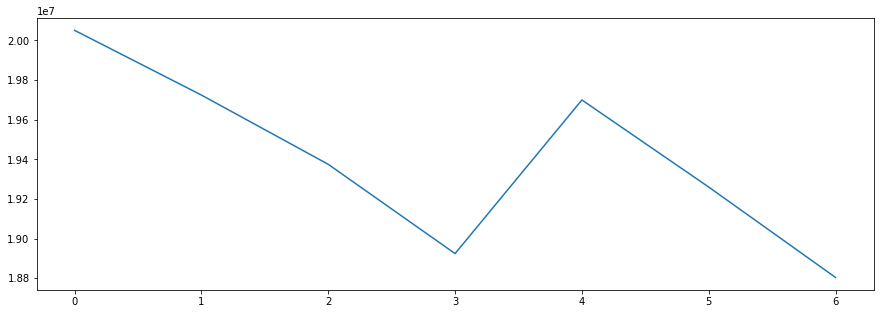

In [38]:
new_model = learn(135, 1000, 100)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 150)
evaluate(new_model)

epoch:   1 loss: 19.84784317
epoch:  26 loss: 0.00918116
epoch:  51 loss: 0.01200173
epoch:  74 loss: 0.0039042791
epoch:   1 loss: 0.12781262
epoch:  26 loss: 0.00899152
epoch:  51 loss: 0.00469774
epoch:  73 loss: 0.0124496249
epoch:   1 loss: 0.11661337


In [ ]:
new_model = learn(135, 1000, 200)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 250)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 300)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 350)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 400)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 450)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 500)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 550)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 600)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 650)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 700)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 750)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 800)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 850)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 900)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 950)
evaluate(new_model)

In [ ]:
new_model = learn(135, 1000, 1000)
evaluate(new_model)

# 1500

In [ ]:
new_model = learn(1145, 1500, 50)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 100)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 150)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 200)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 250)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 300)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 350)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 400)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 450)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 500)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 550)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 600)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 650)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 700)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 750)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 800)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 850)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 900)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 950)
evaluate(new_model)

In [ ]:
new_model = learn(1145, 1500, 1000)
evaluate(new_model)

# 2s

In [ ]:
new_model = learn(2410, 2000, 50)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 100)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 150)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 200)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 250)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 300)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 350)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 400)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 450)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 500)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 550)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 600)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 650)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 700)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 750)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 800)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 850)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 900)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 950)
evaluate(new_model)

In [ ]:
new_model = learn(2410, 2000, 1000)
evaluate(new_model)

# 5s

In [ ]:
new_model = learn(46, 5000, 50)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 100)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 150)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 200)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 250)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 300)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 350)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 400)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 450)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 500)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 550)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 600)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 650)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 700)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 750)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 800)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 850)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 900)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 950)
evaluate(new_model)

In [ ]:
new_model = learn(46, 5000, 1000)
evaluate(new_model)

# 15s

In [ ]:
new_model = learn(2834, 15000, 50)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 100)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 150)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 200)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 250)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 300)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 350)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 400)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 450)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 500)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 550)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 600)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 650)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 700)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 750)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 800)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 850)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 900)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 950)
evaluate(new_model)

In [ ]:
new_model = learn(2834, 15000, 1000)
evaluate(new_model)